In [1]:
# Data Loader
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
import pytorch_lightning as pl
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
import json
#from CustomDataset import * 
from Horizon_DataLoader import * 
import sys
sys.path.append('../')
from config import *
from file_helper import *
#from Horizon_and_SAM.Horizon import PE_helper
from  PE_helper import *

from pytorch_lightning.callbacks import ModelCheckpoint , Callback

def collate_fn(batch):
    return tuple(zip(*batch))
#=================================
#             Augmentation
#=================================

class CustomDataModule(pl.LightningDataModule):
    def __init__(self ,
                 train_dir ,
                 test_dir , batch_size = 2,
                 num_workers = 0 , img_size=[IMG_WIDTH, IMG_HEIGHT] , use_aug = True ,padding_count = 24 ,c =0.1
                   ):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size      
        self.use_aug = use_aug
        self.padding_count  = padding_count
        self.c = c
        

        pass

    def prepare_data(self) -> None:
        # Download dataset
        pass

    def setup(self, stage):
        # Create dataset...          
                
        self.entire_dataset = CustomDataset(self.train_dir  , use_aug= self.use_aug ,  c=self.c , img_size=self.img_size)
        self.train_ds , self.val_ds = random_split(self.entire_dataset , [0.9, 0.1])        
        self.test_ds = CustomDataset(self.test_dir  , use_aug= False , img_size=self.img_size  )
        
        print("image size ",self.img_size)
        pass

    # ToDo: Reture Dataloader...
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self.train_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=True)
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.val_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=False)
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.test_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=True)

    pass


# Test
dm = CustomDataModule ( train_dir= f"../anno/test_visiable_10_no_cross.json" ,
                       test_dir= f"../anno/test_visiable_10_no_cross.json" , padding_count=1024, c =0.96,  img_size=[1024,512]
                       )


e:\Projects\Layout\Horizon_and_SAM\Horizon
e:\Projects\Layout\Horizon_and_SAM\Horizon


In [2]:
from scipy.ndimage.filters import maximum_filter
def find_N_peaks2(signal, r=29, min_v=0.05, N=None):
    max_v = maximum_filter(signal, size=r, mode='wrap')
    pk_loc = np.where(max_v == signal)[0]
    if(min_v>0):
        pk_loc = pk_loc[signal[pk_loc] > min_v]
    if N is not None:
        order = np.argsort(-signal[pk_loc])
        pk_loc = pk_loc[order[:N]]
        pk_loc = pk_loc[np.argsort(pk_loc)]
    return pk_loc, signal[pk_loc]


a = np.random.randn(1024)
pk_loc , signal = find_N_peaks(a )
print(pk_loc.shape)
print(pk_loc)
print(signal)

(36,)
[  15   49   69  102  123  155  171  194  225  243  270  312  346  397
  426  459  478  497  524  577  595  628  650  707  733  768  800  817
  839  855  881  904  936  957  984 1018]
[2.17740113 2.21120192 1.833847   1.79436575 1.9669381  2.20646083
 2.21626781 2.84246906 1.40693138 1.54715798 1.75828754 3.12273197
 2.67303668 1.71193119 1.23896844 1.90413006 1.76089061 1.93401866
 1.64631345 1.5388362  1.82536669 2.38687682 2.29078856 2.6606013
 2.05926372 2.38262189 2.9877769  2.76416264 1.53713995 2.34436081
 2.01547285 1.87164728 2.01030176 2.18070996 2.43226269 2.89330358]


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\User\anaconda3\envs\Layout\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory e:\Projects\Layout\Horizon_and_SAM\Horizon\output\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


image size  [1024, 512]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | HorizonNet | 81.6 M
-------------------------------------
81.6 M    Trainable params
0         Non-trainable params
81.6 M    Total params
163.165   Total estimated model params size (MB)
c:\Users\User\anaconda3\envs\Layout\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
c:\Users\User\anaconda3\envs\Layout\lib\site-packages\pytorch_lightning\trainer\trainer.py:1613: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you w

Training: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


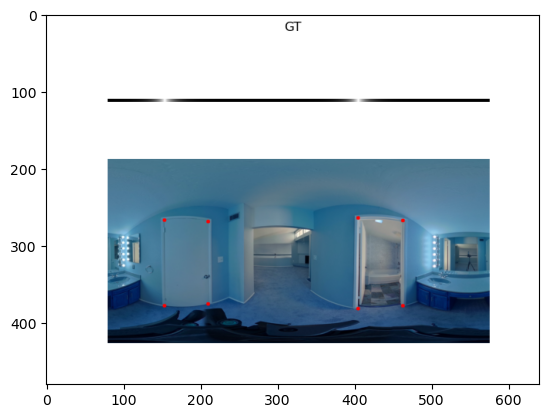

c:\Users\User\anaconda3\envs\Layout\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


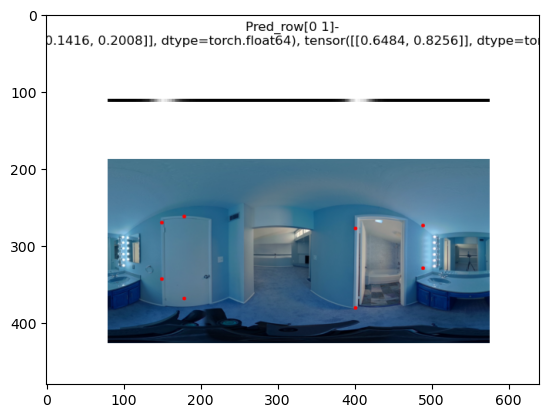

Validation: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
`Trainer.fit` stopped: `max_steps=1` reached.


[val] total_loss tensor(1.4069, device='cuda:0')


In [5]:
from raw_model_pixelwize_bbox import *
from Horizon_DataLoader import  * 
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance

from torch import Tensor
def unpad_data( x :[Tensor] ) :
	non_zero_indices = torch.nonzero(x)
	#print(non_zero_indices)
	# Get the non-zero values
	non_zero_values = x[non_zero_indices[:,0], non_zero_indices[:,1]]

	unique = torch.unique(non_zero_indices[:,0] ,return_counts=True)	
	non_zero_values = torch.split(non_zero_values , tuple(unique[1]))
	
	return non_zero_values
@torch.no_grad()
def pack_visualize( gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , dv_btm_b ):
    
    if isinstance(gt_u_b, torch.Tensor):
        sizes = [t.numel() for t in gt_u_b]               
        us = gt_u_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        us[1::2]+=gt_du_b.flatten()
        us = torch.split(us.view(-1,2) , sizes)

        tops = gt_vtop_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        tops[1::2]=gt_dvtop_b.flatten()
        tops = torch.split(tops.view(-1,2) , sizes)

        btms = gt_vbtm_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        btms[1::2]=dv_btm_b.flatten()
        btms = torch.split(btms.view(-1,2) , sizes)

    elif isinstance(gt_u_b, tuple) and all(isinstance(t, torch.Tensor) for t in gt_u_b):        
        sizes = [len(t) for t in gt_u_b]               
        us = torch.cat(gt_u_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        us[1::2]+=torch.cat(gt_du_b).view(-1)
        us = torch.split(us.view(-1,2) , sizes)

        tops = torch.cat(gt_vtop_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        tops[1::2]=torch.cat(gt_dvtop_b).view(-1)
        tops = torch.split(tops.view(-1,2) , sizes)

        btms = torch.cat(gt_vbtm_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        btms[1::2]=torch.cat(dv_btm_b).view(-1)
        btms = torch.split(btms.view(-1,2) , sizes)
    else:
        assert("Wrong Type.")
    
    return us , tops ,btms

class Model(pl.LightningModule):    
    def __init__(self):
        super().__init__()
        self.model = HorizonNet(backbone='resnet50', use_rnn=True)
        self.log_folder = os.path.join(os.getcwd() , "__test0226" )
        self.post_thrshold = 0.5
        
    def forward(self , x):
        prob , boxs  = self.model(x)  # [ b , _ , 1024]
        prob = prob.permute((0,2,1))
        boxs = boxs.permute((0,2,1))
        

        return prob , boxs
        pass

    def training_step(self , input_b ,batch_idx ):
        img = input_b['image']        
        gt_pro = input_b['u_grad']

        gt_u_b = unpad_data( input_b['u'])          
        gt_vtop_b =unpad_data(input_b['v_top'])
        gt_vbtm_b = unpad_data (input_b['v_btm'])
        gt_du_b = unpad_data(input_b['du'])
        gt_dvtop_b = unpad_data(input_b['dv_top'])
        gt_dv_btm_b = unpad_data(input_b['dv_btm'])

        out_prob , out_boxs = self.forward(img)
        batch_size = out_prob.shape[0]
        
        total_loss = 0
        b_cnt = 0
        for u,vtop,vbtm,du,dvtop, dvbtm , pred_cls , pred_box , gt_cls in zip(gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_prob , out_boxs , gt_pro):
            gt_box =  torch.vstack([ u, vtop,vbtm,  du ,dvtop , dvbtm]).permute(1,0)   # [n , 6]  
            gt_cnt = gt_box.shape[0]

            # Select n peak column
            pkloc , signal = find_N_peaks2( pred_cls.detach().cpu().numpy().astype(np.float32).flatten() , min_v=-2, N=gt_cnt)            
            pred_u = pkloc / 1024
            #print("pkloc" , pkloc)
            #print("pred_u" , pred_u)
            #print("gt u" , u)
            
            # Match gt for each selected peak
            u_cdist =distance.cdist( np.expand_dims(pred_u, axis=-1),  u.unsqueeze(-1).detach().cpu().numpy() )
            row_idx , col_idx = linear_sum_assignment ( u_cdist )

            #print("row_idx " , row_idx)
            #print("col_idx" , col_idx)
            #print("pred_box[row_idx]" , pred_box[row_idx])
            #print("gt_box[col_idx]" , gt_box[col_idx])
            l1_loss = F.l1_loss(pred_box[pkloc][row_idx] , gt_box[col_idx,1:]   )         
            total_loss += l1_loss / gt_cnt

            with torch.no_grad():
                if batch_idx % 5 ==0:
                #if self.current_epoch > 0 and self.current_epoch % 5 == 0  and batch_idx <5 :                
                    save_path =  os.path.join(self.log_folder , f"gt_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )                    
                    # View GT
                    gt_us , gt_tops , gt_btms = pack_visualize(u.view(1 , -1 ) , vtop , vbtm , du , dvtop , dvbtm )                   
                    vis_imgs = visualize_2d_single(gt_us , gt_tops , gt_btms , u_grad =  gt_cls.view(1 , -1 ), imgs= img[b_cnt] , title="GT",save_path=save_path )                
                    plt.imshow(vis_imgs)                    
                    plt.show()
                    
                    # View Prediction
                    #decode_pred = decode_pred_b[row_idx]
                    decode_pred = pred_box[pkloc][row_idx].detach().cpu()
                    save_path =  os.path.join(self.log_folder , f"pred_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )
                    pred_us , pred_tops , pred_btms = pack_visualize( torch.as_tensor(pred_u[row_idx]) , decode_pred[:,0],decode_pred[:,1],
                                                                          decode_pred[:,2] ,decode_pred[:,3],decode_pred[:,4] )                    
                    vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(pred_cls).view(1 , -1 ) , imgs=  img[b_cnt] ,
                                                    title=f"Pred_row{row_idx}-\n u:{pred_us}" , save_path= save_path  )
                    plt.imshow(vis_imgs)                    
                    plt.show()
                pass
            b_cnt+=1
        total_loss/= batch_size
        
        cls_loss = F.binary_cross_entropy_with_logits(out_prob.view(batch_size , -1) , gt_pro.view(batch_size , -1))
        self.log(f"train_cls_loss" , cls_loss)
        self.log(f"train_box_loss" , total_loss)
        total_loss += cls_loss 
        self.log(f"train_total_loss" , total_loss)
        #print("cls_loss" , cls_loss)
        #print("total_loss" , total_loss)
        return total_loss
    
    def validation_step(self, input_b, batch_idx):
        #ToDo...
        img = input_b['image']        
        out_prob , out_boxs = self.forward(img)

        gt_pro = input_b['u_grad']

        gt_u_b = unpad_data( input_b['u'])          
        gt_vtop_b =unpad_data(input_b['v_top'])
        gt_vbtm_b = unpad_data (input_b['v_btm'])
        gt_du_b = unpad_data(input_b['du'])
        gt_dvtop_b = unpad_data(input_b['dv_top'])
        gt_dv_btm_b = unpad_data(input_b['dv_btm'])

        out_prob , out_boxs = self.forward(img)
        batch_size = out_prob.shape[0]
        
        total_loss = 0
        b_cnt = 0
        for u,vtop,vbtm,du,dvtop, dvbtm , pred_cls , pred_box , gt_cls in zip(gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_prob , out_boxs , gt_pro):
            gt_box =  torch.vstack([ u, vtop,vbtm,  du ,dvtop , dvbtm]).permute(1,0)   # [n , 6]  
            gt_cnt = gt_box.shape[0]

            # Select n peak column
            pkloc , signal = find_N_peaks2( pred_cls.detach().cpu().numpy().astype(np.float32).flatten() , min_v=self.post_thrshold, N=None)            
            pred_u = pkloc / 1024
            
            # Match gt for each selected peak
            u_cdist =distance.cdist( np.expand_dims(pred_u, axis=-1),  u.unsqueeze(-1).detach().cpu().numpy() )
            row_idx , col_idx = linear_sum_assignment ( u_cdist )

            l1_loss = F.l1_loss(pred_box[pkloc][row_idx] , gt_box[col_idx,1:]   )         
            total_loss += l1_loss / row_idx.shape[0] +  abs(gt_cnt - row_idx.shape[0])

            with torch.no_grad():
                if batch_idx % 5 ==0:
                #if self.current_epoch > 0 and self.current_epoch % 5 == 0  and batch_idx <5 :                
                    save_path =  os.path.join(self.log_folder , f"val_gt_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )                    
                    # View GT
                    gt_us , gt_tops , gt_btms = pack_visualize(u.view(1 , -1 ) , vtop , vbtm , du , dvtop , dvbtm )                   
                    vis_imgs = visualize_2d_single(gt_us , gt_tops , gt_btms , u_grad =  gt_cls.view(1 , -1 ), imgs= img[b_cnt] , title="GT",save_path=save_path )                
                    #plt.imshow(vis_imgs)                    
                    #plt.show()
                    
                    # View Prediction
                    #decode_pred = decode_pred_b[row_idx]
                    decode_pred = pred_box[pkloc][row_idx].detach().cpu()
                    save_path =  os.path.join(self.log_folder , f"val_pred_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )
                    pred_us , pred_tops , pred_btms = pack_visualize( torch.as_tensor(pred_u[row_idx]) , decode_pred[:,0],decode_pred[:,1],
                                                                          decode_pred[:,2] ,decode_pred[:,3],decode_pred[:,4] )                    
                    vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(pred_cls).view(1 , -1 ) , imgs=  img[b_cnt] ,
                                                    title=f"Pred_row{row_idx}-\n u:{pred_us}" , save_path= save_path  )
                    #plt.imshow(vis_imgs)                    
                    #plt.show()
                pass
            b_cnt+=1
        total_loss/= batch_size
        
        cls_loss = F.binary_cross_entropy_with_logits(out_prob.view(batch_size , -1) , gt_pro.view(batch_size , -1))
        self.log(f"val_cls_loss" , cls_loss)
        self.log(f"val_box_loss" , total_loss)
        total_loss += cls_loss 
        self.log(f"val_total_loss" , total_loss)
        
        print("[val] total_loss" , total_loss)
        return total_loss



        pass
    
    def configure_optimizers(self):
        #ToDo: Look at paper 
        opt = optim.Adam(self.parameters() , lr=0.00035 , betas= (0.9 , 0.999) , weight_decay= 0)
        # Ref: https://github.com/sunset1995/HorizonNet/blob/master/train.py#L44

        return [opt] , []


from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger('tb_logs', name='Horizon_test')

dm = CustomDataModule ( train_dir= f"../../anno/train_visiable_20_no_cross.json" ,
                        test_dir= f"../../anno/test_visiable_10_no_cross.json" ,
                        #test_dir= f"../anno/train_visiable_20_no_cross.json" ,
                        padding_count=1024,
                        use_aug=False , c= 0.96,batch_size=1,
                        img_size=[1024,512]
                       )


save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "test_d20_0226.ckpt")

checkpoint_callback = ModelCheckpoint(
    monitor='val_total_loss',  # The validation metric to monitor
    dirpath= save_path ,  # Directory where checkpoints will be saved
    filename='best-model-{epoch:02d}-{val_loss:.2f}',  # Checkpoint file name
    save_top_k=3,  # Save only the best model
    mode='min'  # 'min' for metrics where lower is better (like loss), 'max' for metrics where higher is better (like accuracy)
)
trainer = pl.Trainer(accelerator='gpu' , devices=1 ,
                    min_epochs=1, max_epochs=51 , precision=16 , fast_dev_run=True ,
                    callbacks=[checkpoint_callback])
m=Model()


m = m.load_from_checkpoint(save_file)
trainer.fit(m , dm)

In [45]:
a = np.random.rand(20)
b = np.expand_dims(a, axis=-1)
print(b.shape)

(20, 1)


In [36]:
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "test_d20.ckpt")
trainer.save_checkpoint(save_file)

In [ ]:
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "test.pth")
#torch.save(m , save_file)
torch.save(m.state_dict(), save_file)